In [9]:
!nvidia-smi

Thu Nov  7 07:33:17 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.03                 Driver Version: 566.03         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   42C    P8              5W /   95W |     608MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [10]:
import torch
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Wed_Feb__8_05:53:42_Coordinated_Universal_Time_2023
Cuda compilation tools, release 12.1, V12.1.66
Build cuda_12.1.r12.1/compiler.32415258_0
torch:  2.5 ; cuda:  cu121


In [11]:
import os
HOME = os.getcwd()
print(HOME)

c:\Users\aadit\work\clg\ml\crowdcounting


## Install YOLOv8

In [12]:
!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics 8.3.28  Python-3.10.15 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 6GB Laptop GPU, 6144MiB)
Setup complete  (12 CPUs, 23.8 GB RAM, 464.9/474.7 GB disk)


## Install Supervision

In [13]:
!pip install supervision

from IPython import display
display.clear_output()

import supervision as sv
print("supervision", sv.__version__)

supervision 0.24.0


In [14]:
!pip install supervision[assets] -q

from IPython import display
display.clear_output()

In [15]:
from supervision.assets import download_assets, VideoAssets
from IPython import display


display.clear_output()

In [16]:
from ultralytics import YOLO

model = YOLO('yolov8s.pt')


0: 736x1280 10 persons, 3 motorcycles, 2 bottles, 2 cups, 19 chairs, 6 dining tables, 1 laptop, 76.7ms
Speed: 5.6ms preprocess, 76.7ms inference, 83.5ms postprocess per image at shape (1, 3, 736, 1280)


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


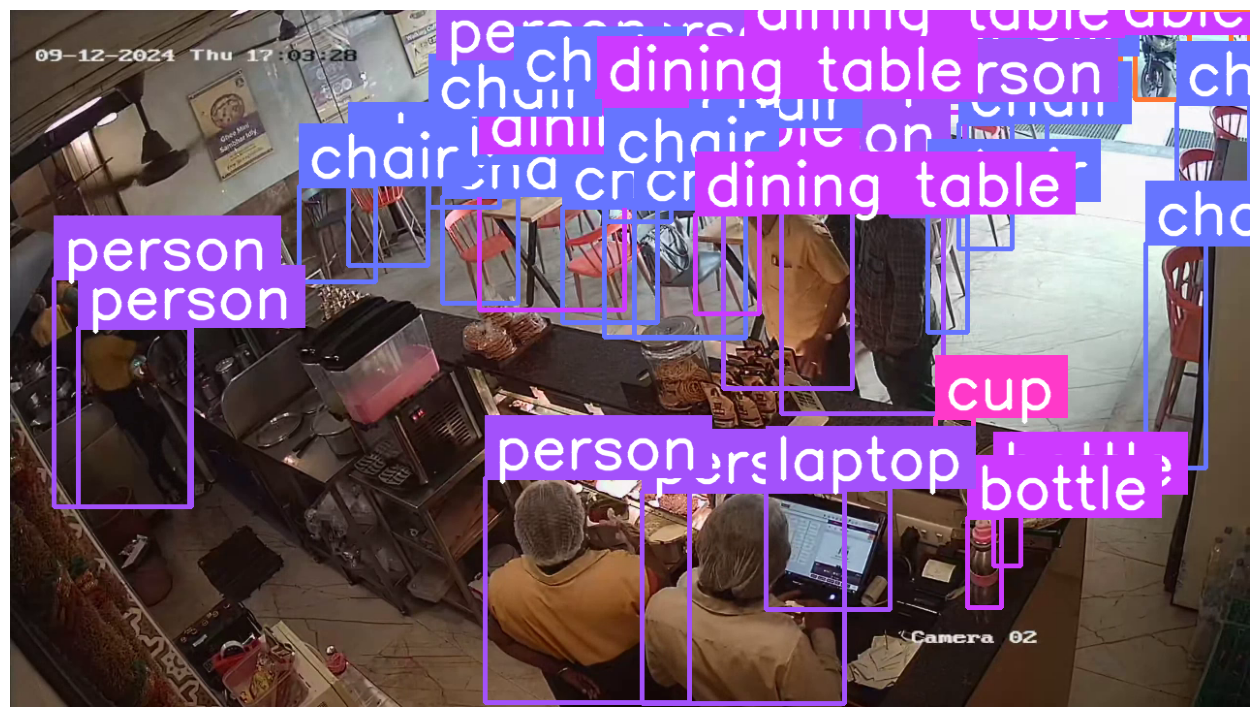

In [17]:
import supervision as sv

# extract video frame
generator = sv.get_video_frames_generator('crowdsample.mp4')
iterator = iter(generator)
frame = next(iterator)

# detect
results = model(frame, imgsz=1280)[0]
detections = sv.Detections.from_ultralytics(results)

# annotate
box_annotator = sv.BoundingBoxAnnotator(thickness=4)
label_annotator = sv.LabelAnnotator(text_thickness=4, text_scale=2)
frame = box_annotator.annotate(scene=frame, detections=detections)
frame = label_annotator.annotate(scene=frame, detections=detections)

%matplotlib inline
sv.plot_image(frame, (16, 16))


0: 736x1280 10 persons, 3 motorcycles, 2 bottles, 2 cups, 19 chairs, 6 dining tables, 1 laptop, 25.6ms
Speed: 3.0ms preprocess, 25.6ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


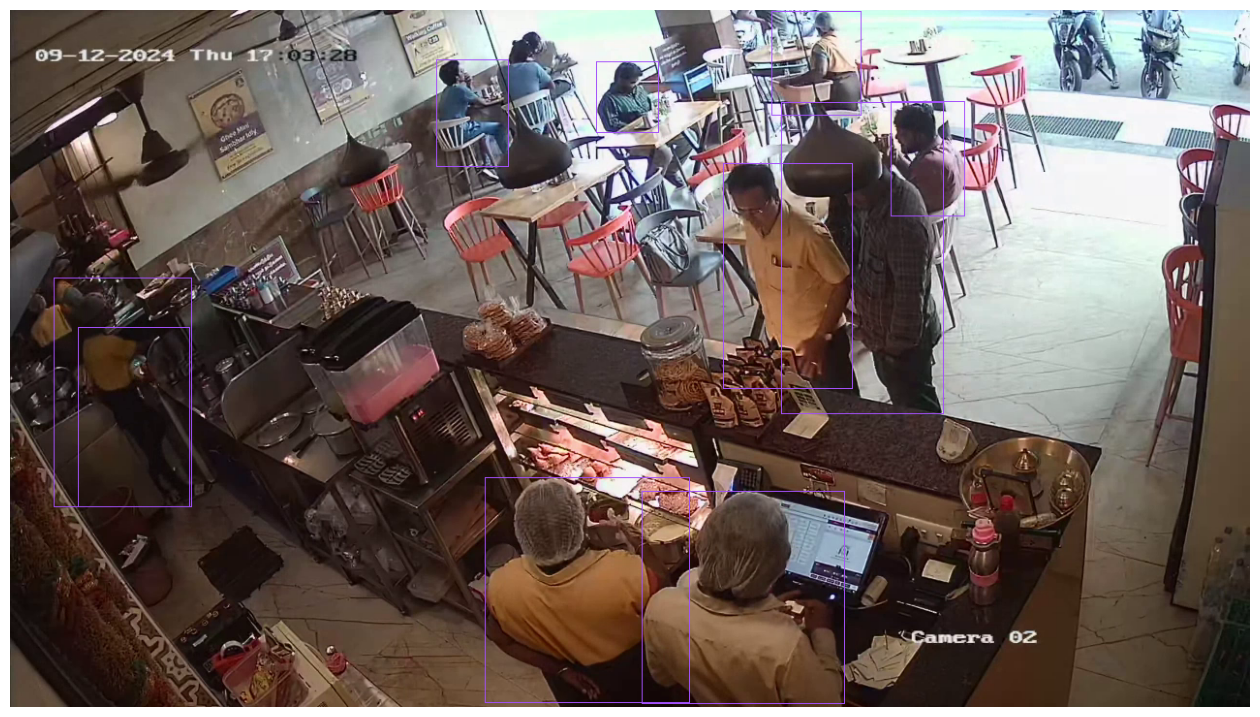

In [18]:
# Extract video frame
generator = sv.get_video_frames_generator('crowdsample.mp4')
iterator = iter(generator)
frame = next(iterator)

# Detect objects in the frame
results = model(frame, imgsz=1280)[0]
detections = sv.Detections.from_ultralytics(results)

# Filter detections to only include class_id == 0 (e.g., "person") and confidence >= 0.2
detections = detections[(detections.class_id == 0) & (detections.confidence >= 0.2)]

# Annotate the bounding boxes only, without labels
box_annotator = sv.BoundingBoxAnnotator(thickness=1)
frame = box_annotator.annotate(scene=frame, detections=detections)

# Display the annotated frame
%matplotlib inline
sv.plot_image(frame, (16, 16))


In [19]:
sv.VideoInfo.from_video_path('crowdsample.mp4')


VideoInfo(width=1280, height=720, fps=30, total_frames=941)


0: 736x1280 10 persons, 3 motorcycles, 2 bottles, 2 cups, 19 chairs, 6 dining tables, 1 laptop, 29.9ms
Speed: 5.6ms preprocess, 29.9ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


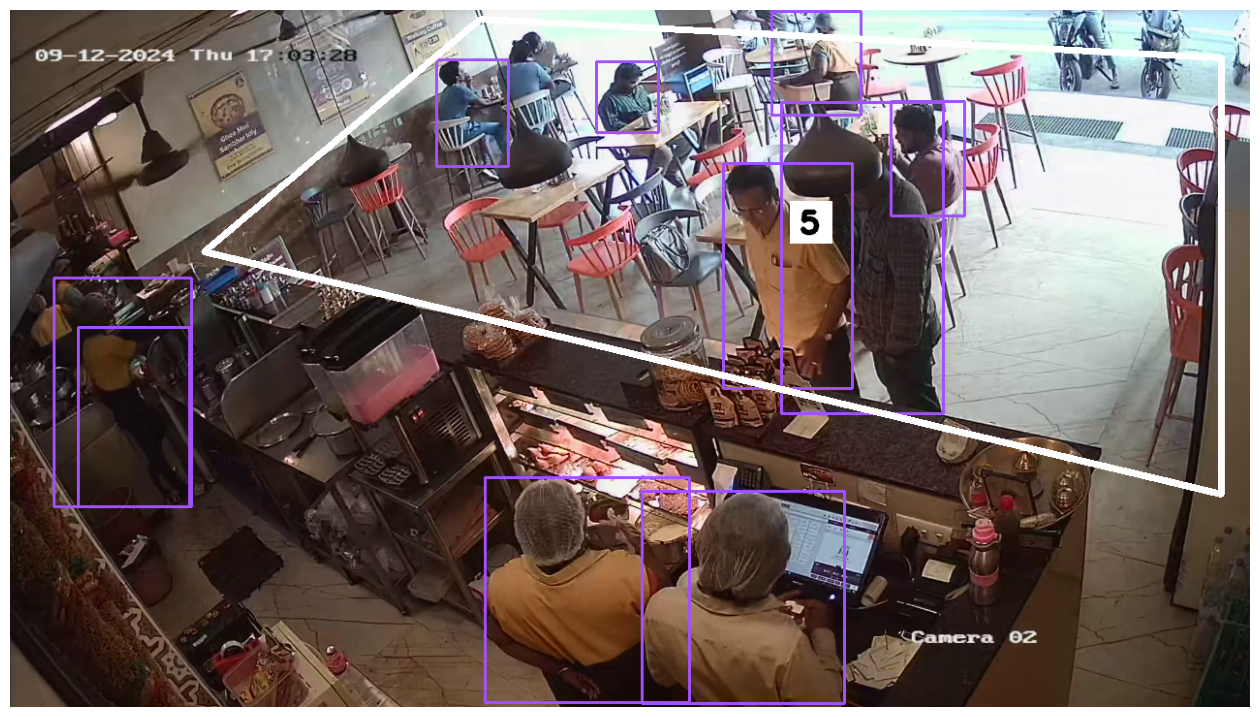

In [ ]:
import numpy as np

# Initiate polygon zone
polygon = np.array([
    [485, 10],   # Top-left corner
    [1250, 50],  # Top-right corner
    [1250, 500],  # Bottom-right corner
    [200, 250]    # Bottom-left corner
])


video_info = sv.VideoInfo.from_video_path('crowdsample.mp4')
zone = sv.PolygonZone(polygon=polygon)

# Initiate annotators
box_annotator = sv.BoundingBoxAnnotator(thickness=2)  # Set thickness to 1
zone_annotator = sv.PolygonZoneAnnotator(zone=zone, color=sv.Color.WHITE, thickness=6, text_thickness=3, text_scale=1)

# Extract video frame
generator = sv.get_video_frames_generator('crowdsample.mp4')
iterator = iter(generator)
frame = next(iterator)

# Detect
results = model(frame, imgsz=1280)[0]
detections = sv.Detections.from_ultralytics(results)
detections = detections[detections.class_id == 0]
zone.trigger(detections=detections)

# Annotate only the bounding boxes (remove labels)
frame = box_annotator.annotate(scene=frame, detections=detections)
frame = zone_annotator.annotate(scene=frame)

# Display the frame
%matplotlib inline
sv.plot_image(frame, (16, 16))



0: 736x1280 10 persons, 3 motorcycles, 2 bottles, 2 cups, 19 chairs, 6 dining tables, 1 laptop, 30.0ms
Speed: 5.0ms preprocess, 30.0ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


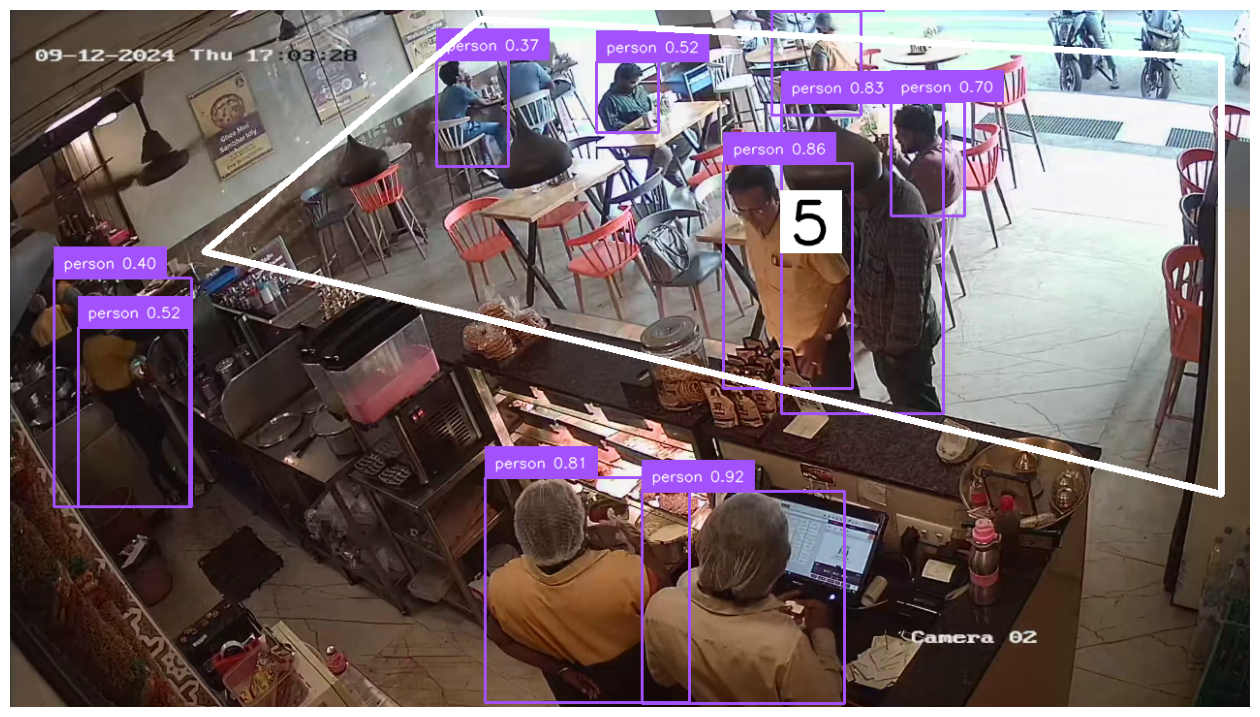

In [ ]:
# Initiate polygon zone
polygon = np.array([
    [485, 10],   # Top-left corner
    [1250, 50],  # Top-right corner
    [1250, 500],  # Bottom-right corner
    [200, 250]    # Bottom-left corner
])
video_info = sv.VideoInfo.from_video_path('crowdsample.mp4')
zone = sv.PolygonZone(polygon=polygon)

# initiate annotators
box_annotator = sv.BoundingBoxAnnotator(thickness=2)
label_annotator = sv.LabelAnnotator(text_thickness=1, text_scale=0.5)
zone_annotator = sv.PolygonZoneAnnotator(zone=zone, color=sv.Color.WHITE, thickness=6, text_thickness=3, text_scale=2)

# extract video frame
generator = sv.get_video_frames_generator('crowdsample.mp4')
iterator = iter(generator)
frame = next(iterator)

# detect
results = model(frame, imgsz=1280)[0]
detections = sv.Detections.from_ultralytics(results)
detections = detections[detections.class_id == 0]
zone.trigger(detections=detections)

# annotate
labels = [f"{model.names[class_id]} {confidence:0.2f}" for _, _, confidence, class_id, _, _ in detections]
frame = box_annotator.annotate(scene=frame, detections=detections)
frame = label_annotator.annotate(scene=frame, detections=detections, labels=labels)
frame = zone_annotator.annotate(scene=frame)

%matplotlib inline
sv.plot_image(frame, (16, 16))

In [15]:
import numpy as np
import os
from collections import deque
import cv2
from IPython import display

# Initialize the video info and annotators
video_info = sv.VideoInfo.from_video_path('crowdsample.mp4')

# Use the updated `BoxAnnotator` instead of `BoundingBoxAnnotator`
box_annotator = sv.BoxAnnotator(thickness=2)
label_annotator = sv.LabelAnnotator(text_thickness=1, text_scale=0.5)

# Buffer to store the last 10 frame counts
frame_count_buffer = deque(maxlen=10)

def process_frame(frame: np.ndarray, _) -> np.ndarray:
    # Run detection
    results = model(frame, imgsz=1600)[0]
    detections = sv.Detections.from_ultralytics(results)

    # Filter only for the 'person' class (assuming class_id=0 represents 'person')
    detections = detections[detections.class_id == 0]

    # Add the current frame's count to the buffer
    frame_count_buffer.append(len(detections))

    # Calculate the average count over the last 10 frames for stability
    avg_count = int(np.mean(frame_count_buffer))

    # Annotate bounding boxes and labels
    labels = [f"{model.names[class_id]} {confidence:0.2f}" for _, _, confidence, class_id, _, _ in detections]
    frame = box_annotator.annotate(scene=frame, detections=detections)
    frame = label_annotator.annotate(scene=frame, detections=detections, labels=labels)

    # Overlay the stable average count on the frame
    cv2.putText(frame, f"Average People Count: {avg_count}", (50, 50),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    return frame

# Define source and target paths for the video
source_dir = os.path.dirname('crowdsample.mp4')
target_path = os.path.join(source_dir, 'result.mp4')

# Process the video with the modified process_frame function
sv.process_video(source_path='crowdsample.mp4', target_path=target_path, callback=process_frame)

# Clear output in Jupyter
display.clear_output()


In [16]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from pathlib import Path
from xml.dom.minidom import parse
from shutil import copyfile
import os
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# !mkdir -p Dataset/labels
# !mkdir -p Dataset/images
# classes = ['Cap','No_Cap']

In [10]:
from pathlib import Path
import xml.etree.ElementTree as ET
from shutil import copyfile
import os
import numpy as np
import pandas as pd

In [12]:
classes = ['Cap','No_Cap']
def convert_annot(size , box):
    x1 = int(box[0])
    y1 = int(box[1])
    x2 = int(box[2])
    y2 = int(box[3])

    dw = np.float32(1. / int(size[0]))
    dh = np.float32(1. / int(size[1]))

    w = x2 - x1
    h = y2 - y1
    x = x1 + (w / 2)
    y = y1 + (h / 2)

    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return [x, y, w, h]

In [ ]:
# def save_txt_file(img_jpg_file_name, size, img_box):
#     # Define the output file path to save in the root directory
#     save_file_name = '/' + img_jpg_file_name + '.txt'

#     with open(save_file_name, 'a+') as file_path:
#         for box in img_box:
#             cls_num = classes.index(box[0])
#             new_box = convert_annot(size, box[1:])
#             file_path.write(f"{cls_num} {new_box[0]} {new_box[1]} {new_box[2]} {new_box[3]}\n")

#         file_path.flush()
#         file_path.close()


In [ ]:
# def get_xml_data(file_path, img_xml_file):
#     img_path = file_path + '/' + img_xml_file + '.xml'

#     tree = ET.parse(img_path)
#     root = tree.getroot()

#     img_name = root.find("filename").text
#     img_size = root.find("size")
#     img_w = int(img_size.find("width").text)
#     img_h = int(img_size.find("height").text)
#     img_c = int(img_size.find("depth").text)

#     img_box = []
#     for box in root.findall("object"):
#         cls_name = box.find("name").text
#         x1 = int(box.find("bndbox").find("xmin").text)
#         y1 = int(box.find("bndbox").find("ymin").text)
#         x2 = int(box.find("bndbox").find("xmax").text)
#         y2 = int(box.find("bndbox").find("ymax").text)

#         img_box.append([cls_name, x1, y1, x2, y2])

#     img_jpg_file_name = img_xml_file + '.jpg'
#     save_txt_file(img_xml_file, [img_w, img_h], img_box)

In [13]:
!pip install scikit-learn

In [ ]:

import yaml
import os
import random
from sklearn.model_selection import train_test_split

# Path to the YAML file
yaml_path = r'C:\Users\aadit\work\clg\ml\crowdcounting\data\data.yaml'

# Load the YAML file
with open(yaml_path, 'r') as file:
    data = yaml.safe_load(file)

# Print out the data to see what it contains
print("Dataset Information from data.yaml:")
print(data)

# Correct the access to the keys in the YAML file
# train_txt_path = data[r'C:\Users\aadit\work\clg\ml\crowdcounting\data\Train.txt']  # Path to the Train.txt file (annotations)
class_names = data['names']  # Class names

# Define the path to the images and labels folder
#images are stored in three different folders
images_path = r'C:\Users\aadit\work\clg\ml\crowdcounting\headcap1\images'
labels_path = r'C:\Users\aadit\work\clg\ml\crowdcounting\headcap1\labels'

# Get the list of image files (assuming images are in the 'images' folder)
# image_files = [f for f in os.listdir(images_path) if f.endswith('.jpg') or f.endswith('.png')]

# # Print the first few image files to check
# print("First few image files:", image_files[:5])

#the data is stored in three different folders and is already split into train, test and validation


# Print out the splits
#print the number of images in each folder
train_set_size = len(os.listdir('data/train/images'))
val_set_size = len(os.listdir('data/val/images'))
test_set_size = len(os.listdir('data/test/images'))
print(f"Train set size: {train_set_size}")
print(f"Validation set size: {val_set_size}")
print(f"Test set size: {test_set_size}")

# # Update the data.yaml file paths for the new split (optional)
# data['train'] = 'C:\Users\aadit\work\clg\ml\crowdcounting\data\train\images'  # Path to training images
# data['val'] = 'C:\Users\aadit\work\clg\ml\crowdcounting\data\val\images'    # Path to validation images
# data['test'] = 'C:\Users\aadit\work\clg\ml\crowdcounting\data\test\images'  # Path to test images

# # Write the updated YAML file back (optional)
# with open('C:\Users\aadit\work\clg\ml\crowdcounting\data\data.yaml', 'w') as outfile:
#     yaml.dump(data, outfile, default_flow_style=False)

# # If you want to check the new YAML content:
# with open('C:\Users\aadit\work\clg\ml\crowdcounting\data\data.yaml', 'r') as file:
#     updated_data = yaml.safe_load(file)
# print("Updated Dataset Information:")
# print(updated_data)


Dataset Information from data.yaml:
{'labels': {'test': 'C:\\Users\\aadit\\work\\clg\\ml\\crowd counting\\data\\test\\labels', 'train': 'C:\\Users\\aadit\\work\\clg\\ml\\crowd counting\\data\\train\\labels', 'val': 'C:\\Users\\aadit\\work\\clg\\ml\\crowd counting\\data\\val\\labels'}, 'names': ['Cap', 'No_Cap'], 'nc': 2, 'test': 'C:\\Users\\aadit\\work\\clg\\ml\\crowd counting\\data\\test\\images', 'train': 'C:\\Users\\aadit\\work\\clg\\ml\\crowd counting\\data\\train\\images', 'val': 'C:\\Users\\aadit\\work\\clg\\ml\\crowd counting\\data\\val\\images'}
Train set size: 247
Validation set size: 30
Test set size: 32


In [15]:
!git clone https://github.com/ultralytics/ultralytics
!pip install ultralytics

'git' is not recognized as an internal or external command,
operable program or batch file.


# New Section

In [ ]:
# import yaml

# # Create configuration with paths for both images and labels
# config = {
#    "train": r"C:\Users\aadit\work\clg\ml\crowdcounting\data\train\images"
#    "val": r"C:\Users\aadit\work\clg\ml\crowdcounting\data\val\images",      # Path to validation images
#    "test": r"C:\Users\aadit\work\clg\ml\crowdcounting\data\test\images",    # Path to test images
#    "labels": {  # Add paths for label files
#        "train": r"C:\Users\aadit\work\clg\ml\crowdcounting\data\train\labels",  # Path to training labels
#        "val": r"C:\Users\aadit\work\clg\ml\crowdcounting\data\val\labels",      # Path to validation labels
#        "test": r"C:\Users\aadit\work\clg\ml\crowdcounting\data\test\labels",    # Path to test labels
#    },
#    "nc": 2,  # Number of classes
#    "names": ['Cap', 'No_Cap']  # Class names: 'Cap' and 'No_Cap'
# }

# # Save the updated configuration to a new YAML file
# with open(r"C:\Users\aadit\work\clg\ml\crowdcounting\data\data.yaml", "w") as file:  # Save the updated YAML file
#    yaml.dump(config, file, default_flow_style=False)

# print("Configuration saved to r 'C:\Users\aadit\work\clg\ml\crowdcounting\data\data.yaml'")


Configuration saved to '/content/data_updated.yaml'


In [ ]:
#show contents of the data.yaml file
with open(r"C:\Users\aadit\work\clg\ml\crowdcounting\data\data.yaml", 'r') as file:
    data = yaml.safe_load(file)
print("Dataset Information from data.yaml:")
print(data)

Dataset Information from data.yaml:
{'labels': {'test': 'C:\\Users\\aadit\\work\\clg\\ml\\crowd counting\\data\\test\\labels', 'train': 'C:\\Users\\aadit\\work\\clg\\ml\\crowd counting\\data\\train\\labels', 'val': 'C:\\Users\\aadit\\work\\clg\\ml\\crowd counting\\data\\val\\labels'}, 'names': ['Cap', 'No_Cap'], 'nc': 2, 'test': 'C:\\Users\\aadit\\work\\clg\\ml\\crowd counting\\data\\test\\images', 'train': 'C:\\Users\\aadit\\work\\clg\\ml\\crowd counting\\data\\train\\images', 'val': 'C:\\Users\\aadit\\work\\clg\\ml\\crowd counting\\data\\val\\images'}


In [17]:
import torch

if torch.cuda.is_available():
    print("GPU is available and being used.")
    device = torch.device("cuda")
else:
    print("GPU is NOT available, running on CPU.")
    device = torch.device("cpu")

print("Using device:", device)


GPU is available and being used.
Using device: cuda


In [ ]:
from ultralytics import YOLO

# Load the YOLOv8 model (pre-trained or custom)
model = YOLO("yolov8n.pt")  # Use the small YOLOv8 model, replace with your custom model if applicable

# Start the training process
model.train(data=r"C:\Users\aadit\work\clg\ml\crowdcounting\data\data.yaml", epochs=20, batch=8, imgsz=640)

# After training, you can evaluate the model
model.val()

# If you need to save the model after training, use the following:
model.save(r"C:\Users\aadit\work\clg\ml\crowdcounting\data\yolov8n_trained.pt")


In [19]:
from IPython.display import Image, clear_output
import matplotlib.pyplot as plt
%matplotlib inline

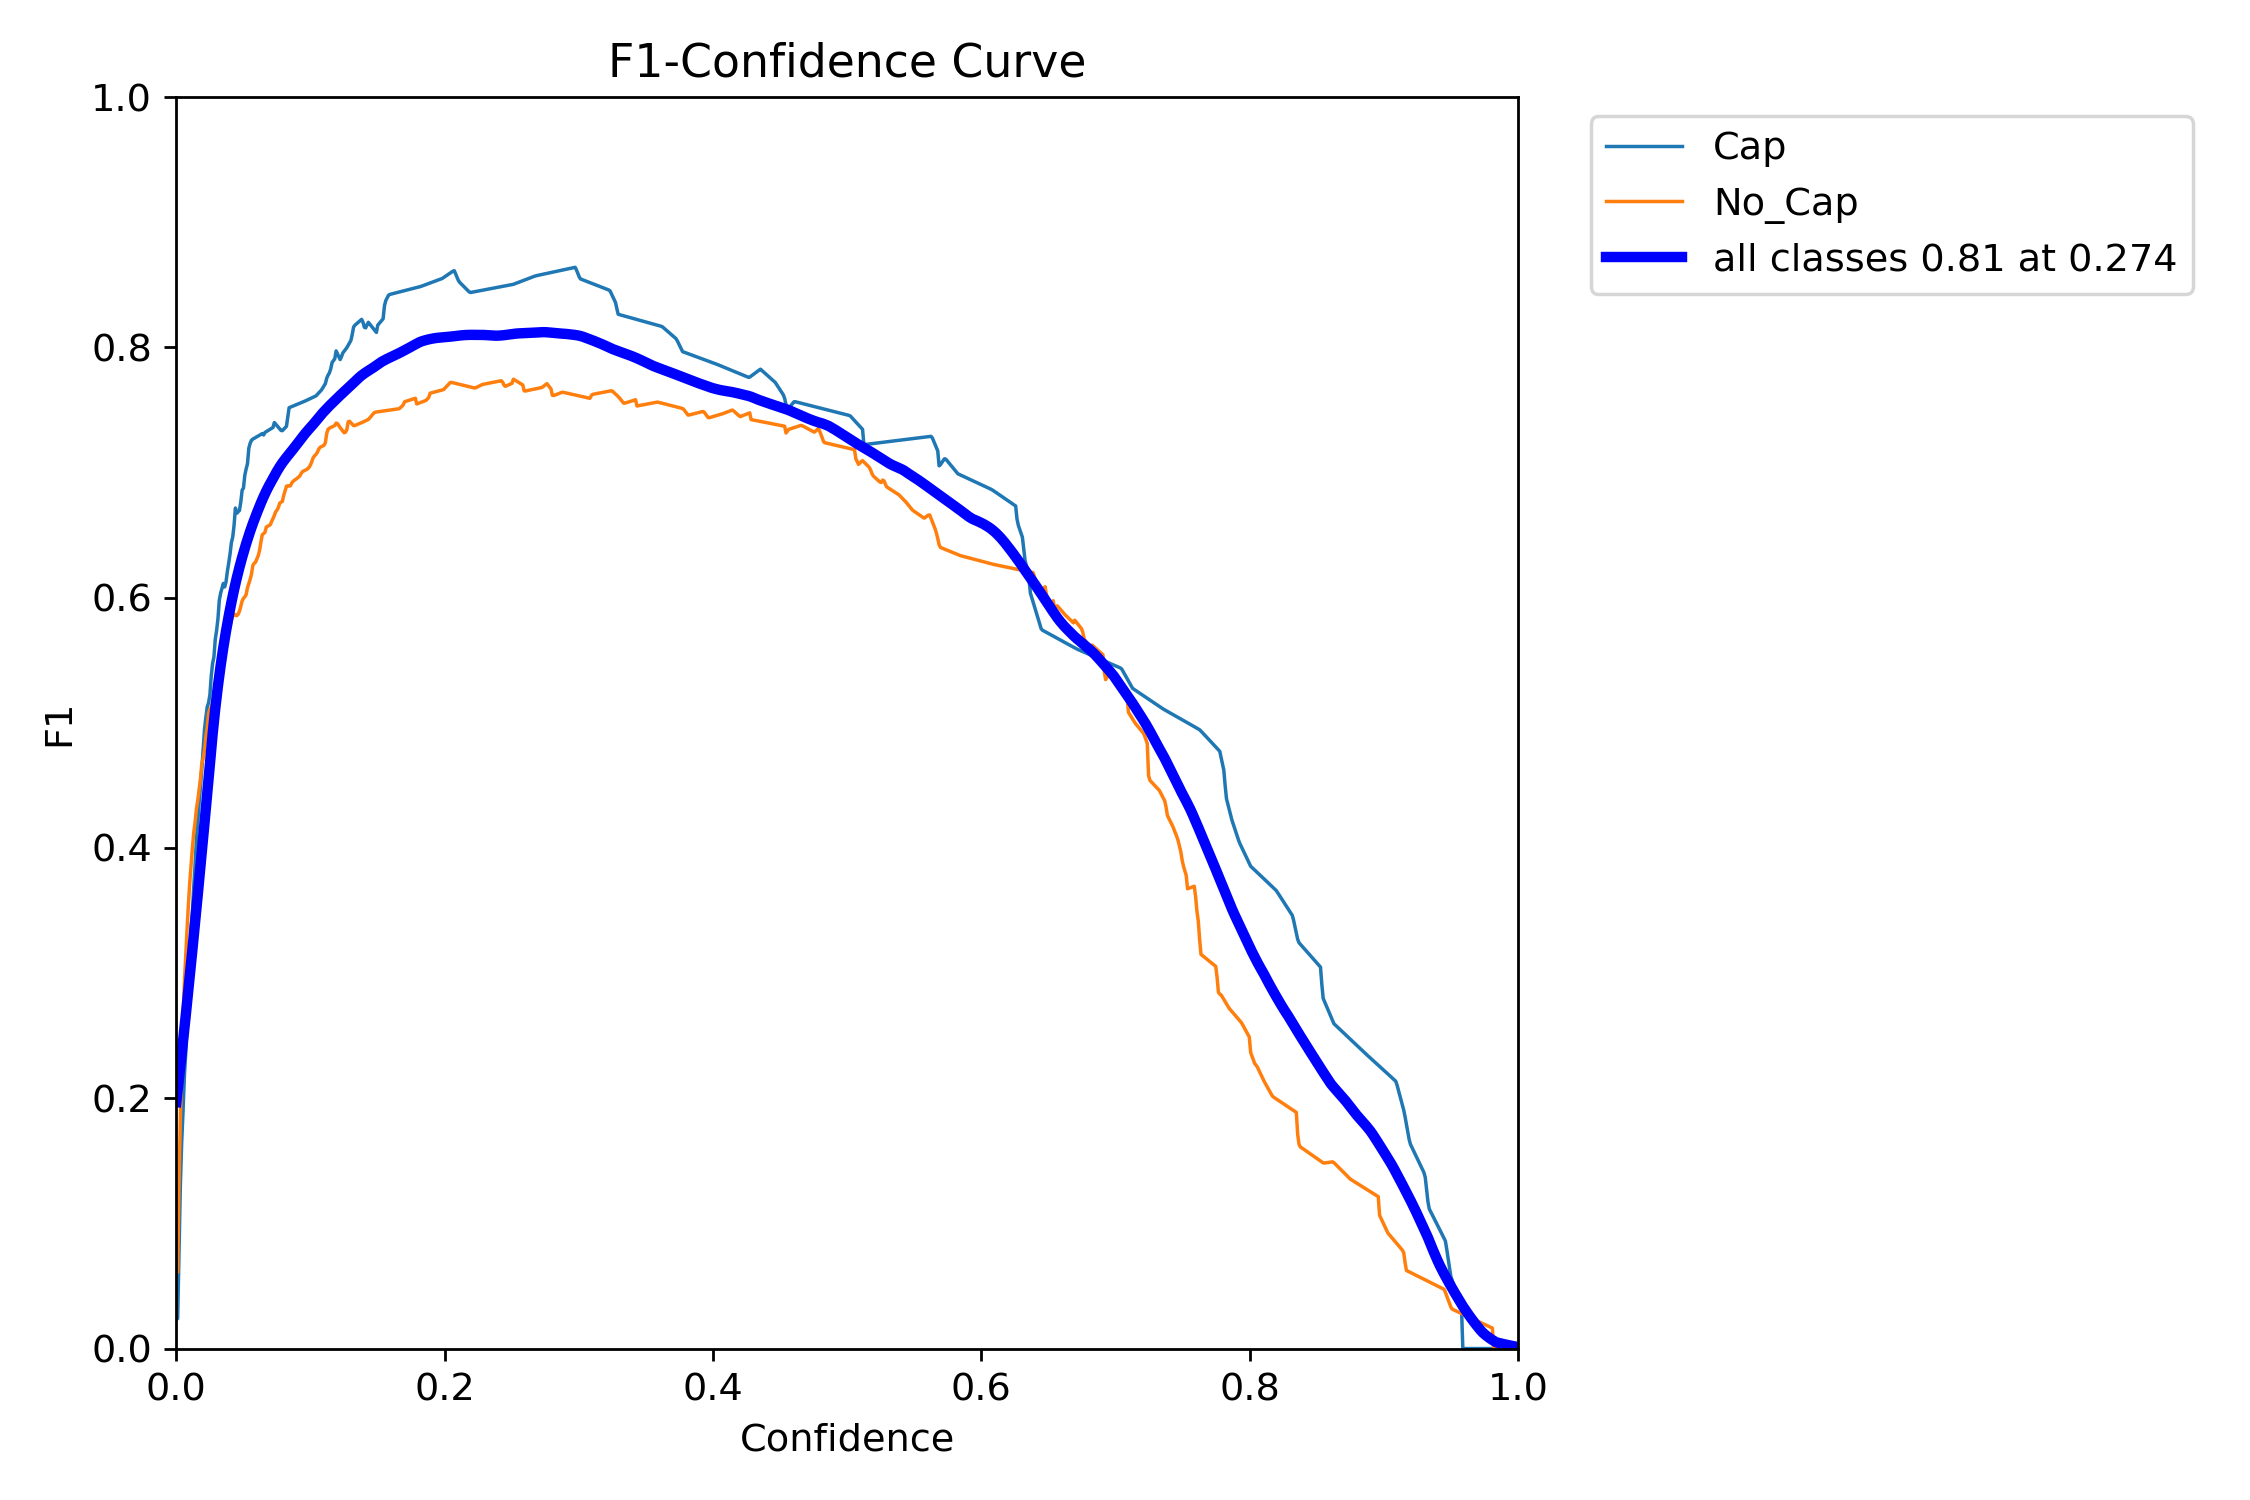

In [ ]:
Image(filename=r'C:\Users\aadit\work\clg\ml\crowdcounting\runs\detect\train52\F1_curve.png')

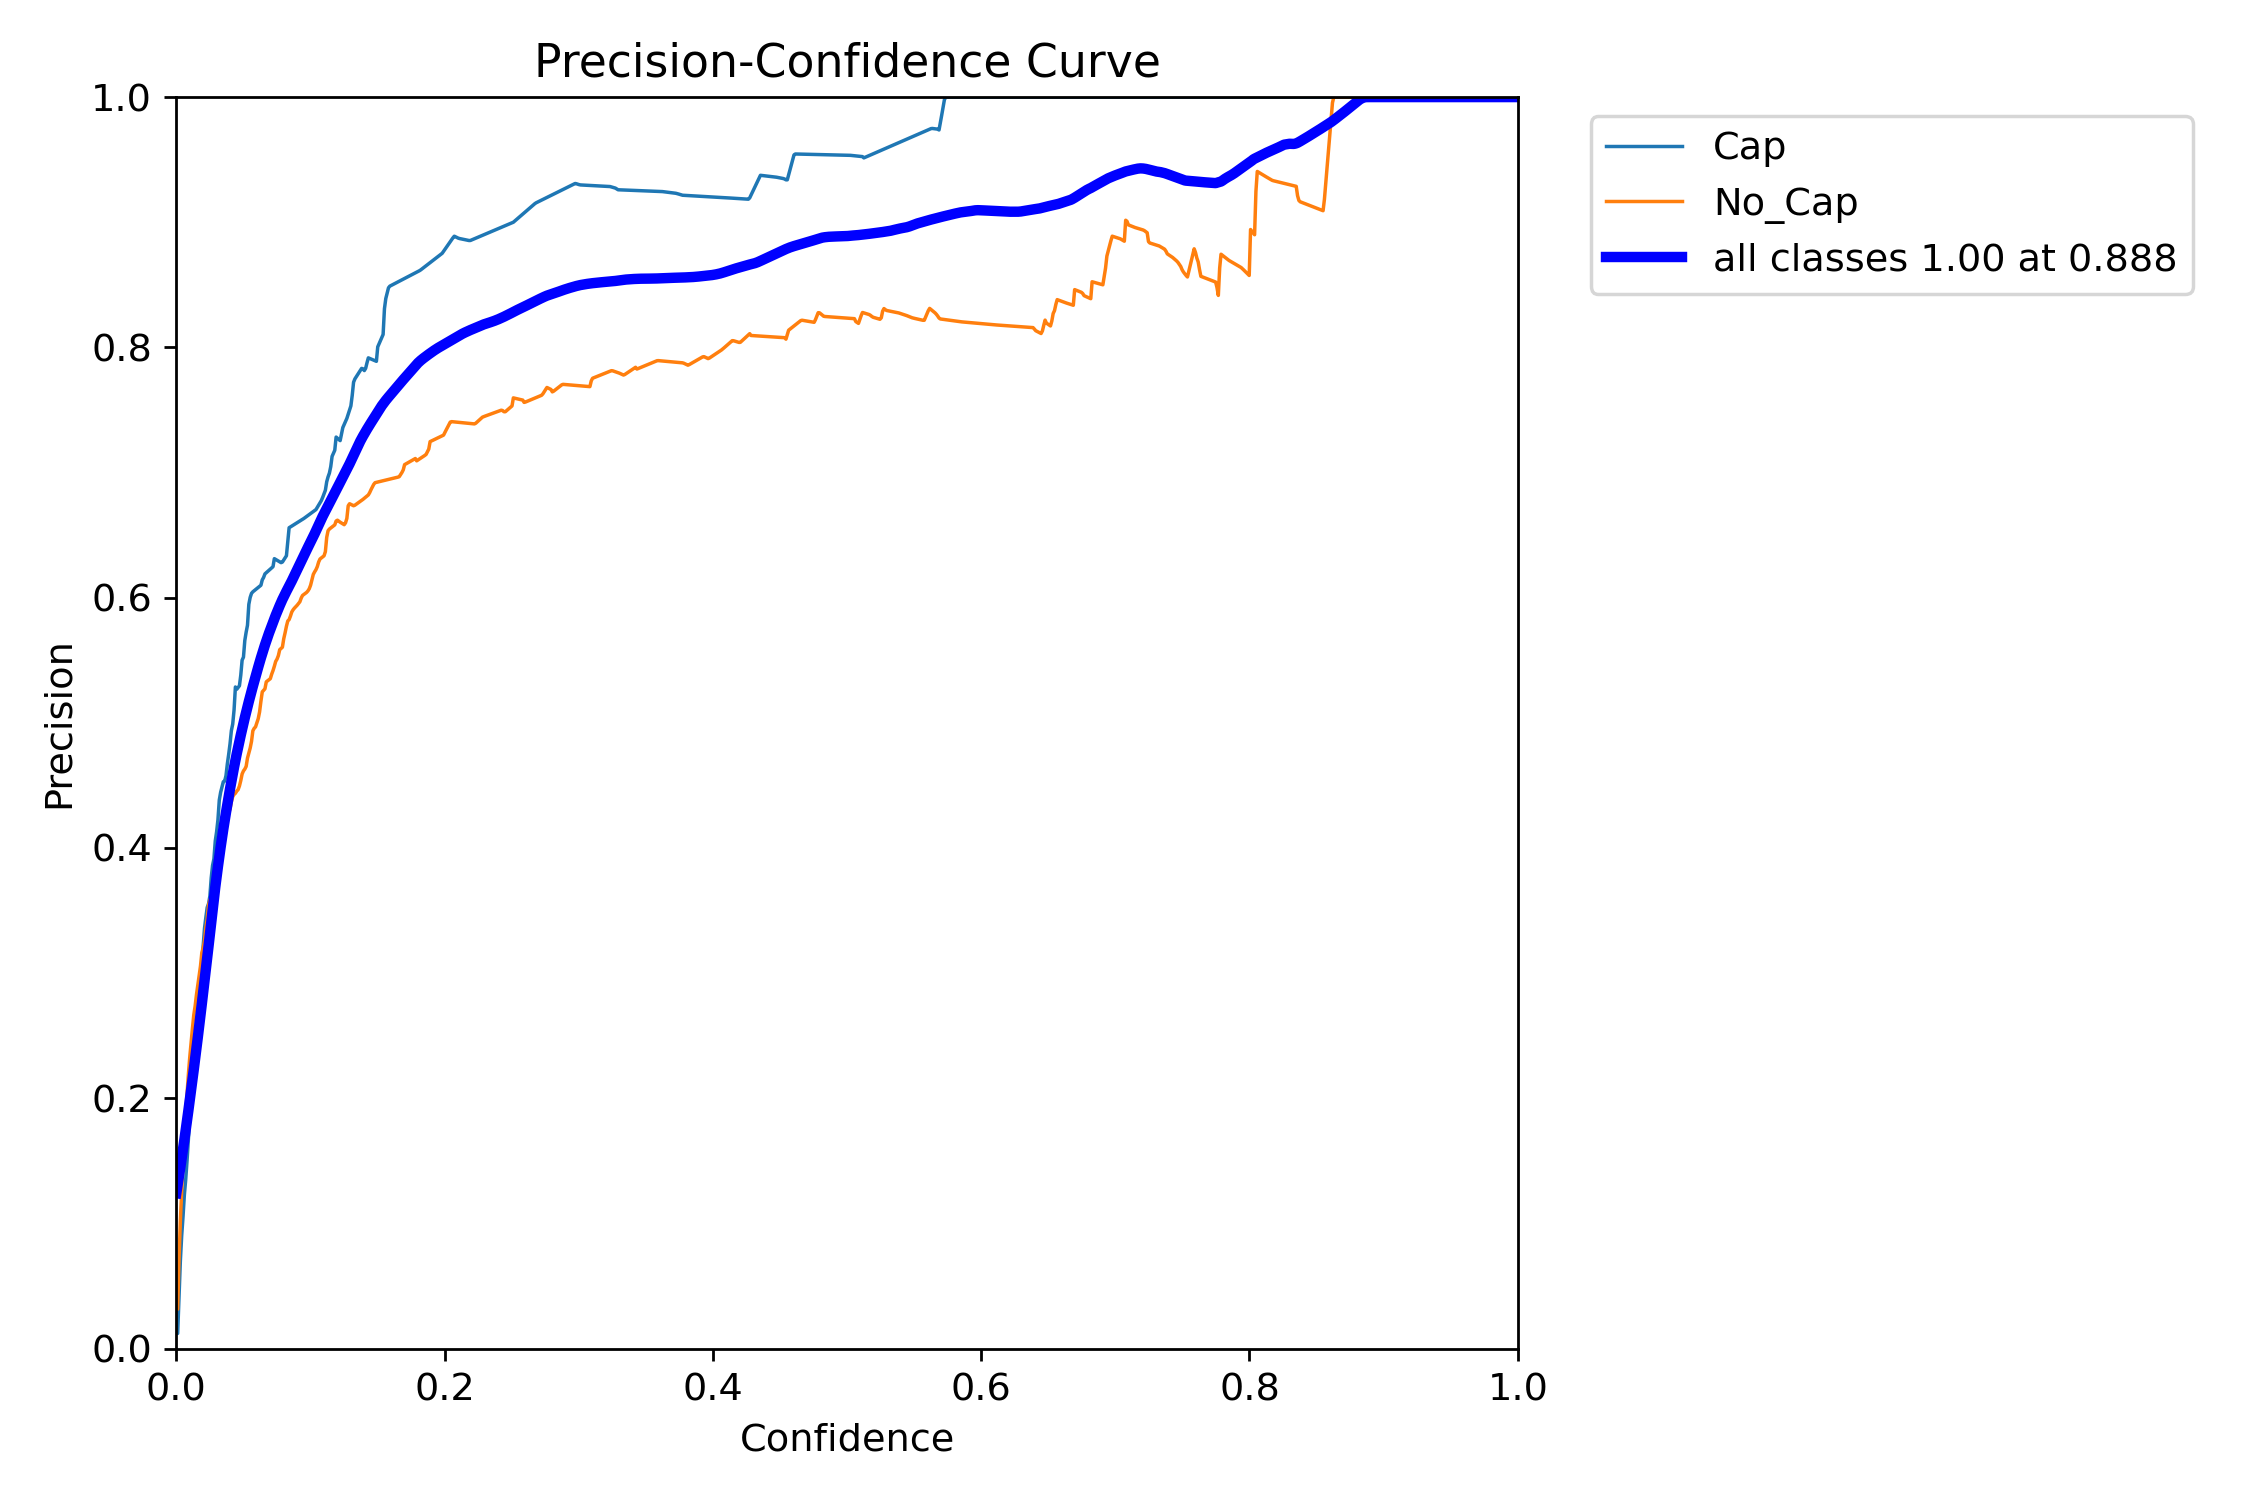

In [ ]:
Image(filename=r'C:\Users\aadit\work\clg\ml\crowdcounting\runs\detect\train52\P_curve.png')

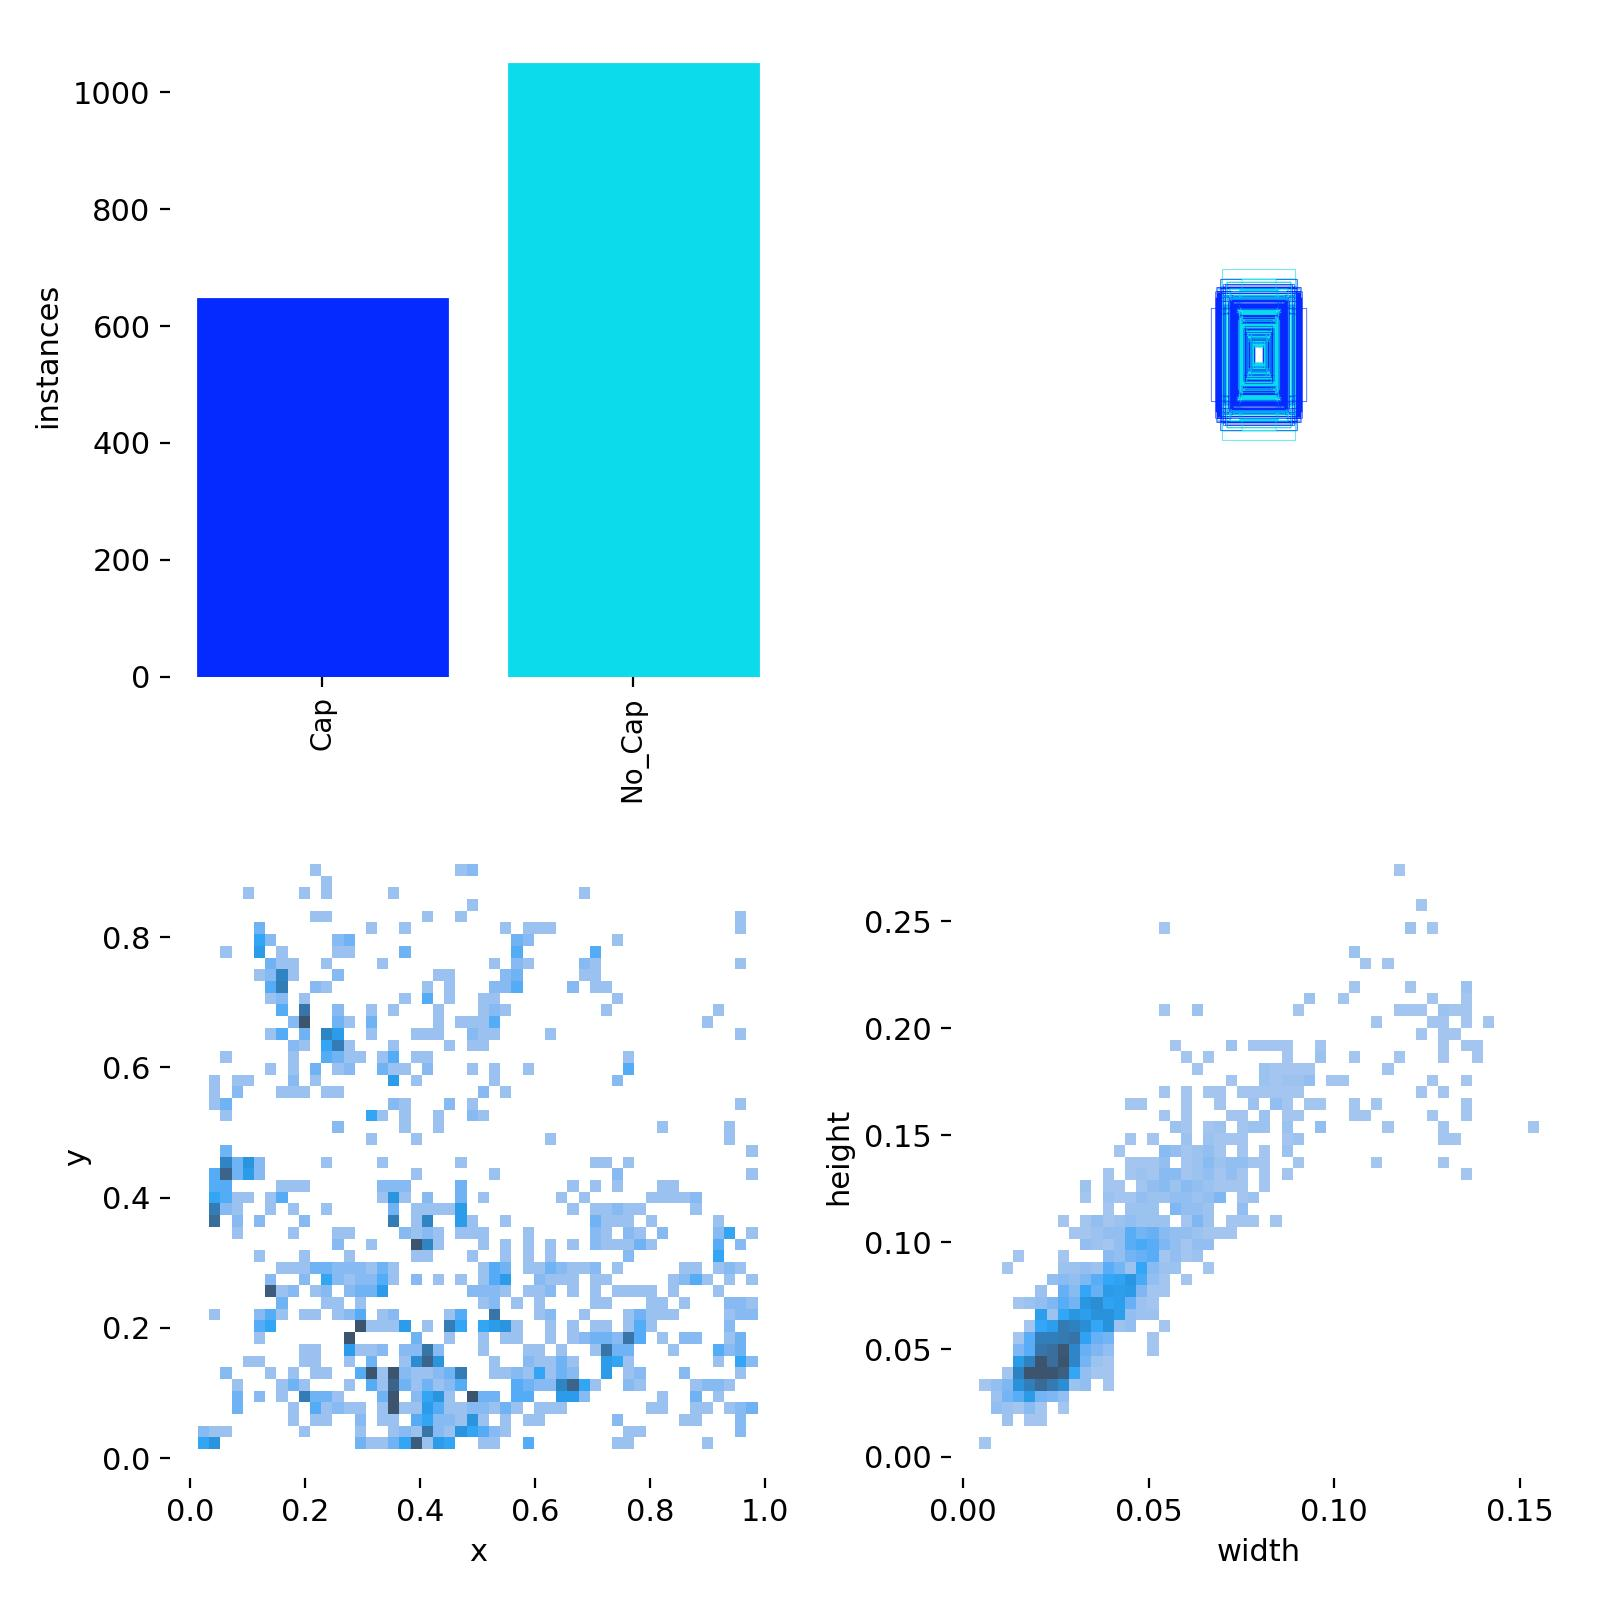

In [ ]:
Image(filename=r'C:\Users\aadit\work\clg\ml\crowdcounting\runs\detect\train\labels.jpg')

In [ ]:
%pip install plotly
import plotly.express as px
%pip install nbformat

In [ ]:
# import plotly.express as px
# import pandas as pd

# df = pd.read_csv(r'C:\Users\aadit\work\clg\ml\crowdcounting\runs\detect\train\results.csv')
# fig = px.line(df, x='epoch', y='metrics/precision(B)', title='Precision vs. Epoch')
# fig.show()

In [1]:
!yolo task=detect mode=val model=r'C:\\Users\\aadit\\work\\clg\\ml\\crowdcounting\\data\\yolov8n_trained.pt' data=r'C:\\Users\\aadit\\work\\clg\\ml\\crowdcounting\\data\\data.yaml' imgsz=640

Ultralytics 8.3.28 🚀 Python-3.10.15 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 6GB Laptop GPU, 6144MiB)


Traceback (most recent call last):
  File "C:\Users\aadit\anaconda3\envs\testing\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\aadit\anaconda3\envs\testing\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "C:\Users\aadit\anaconda3\envs\testing\Scripts\yolo.exe\__main__.py", line 7, in <module>
  File "C:\Users\aadit\anaconda3\envs\testing\lib\site-packages\ultralytics\cfg\__init__.py", line 966, in entrypoint
    getattr(model, mode)(**overrides)  # default args from model
  File "C:\Users\aadit\anaconda3\envs\testing\lib\site-packages\ultralytics\engine\model.py", line 635, in val
    validator(model=self.model)
  File "C:\Users\aadit\anaconda3\envs\testing\lib\site-packages\torch\utils\_contextlib.py", line 116, in decorate_context
    return func(*args, **kwargs)
  File "C:\Users\aadit\anaconda3\envs\testing\lib\site-packages\ultralytics\engine\validator.py", line 145, in __call__
    self.data 

In [2]:
!yolo task=evaluate mode=val model=r'C:\\Users\\aadit\\work\\clg\\ml\\crowdcounting\\data\\yolov8n_trained.pt' data=r'C:\\Users\\aadit\\work\\clg\\ml\\crowdcounting\\data\\data.yaml' imgsz=640

Traceback (most recent call last):
  File "C:\Users\aadit\anaconda3\envs\testing\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\aadit\anaconda3\envs\testing\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "C:\Users\aadit\anaconda3\envs\testing\Scripts\yolo.exe\__main__.py", line 7, in <module>
  File "C:\Users\aadit\anaconda3\envs\testing\lib\site-packages\ultralytics\cfg\__init__.py", line 911, in entrypoint
    raise ValueError(f"Invalid 'task={task}'. Valid tasks are {TASKS}.\n{CLI_HELP_MSG}")
ValueError: Invalid 'task=evaluate'. Valid tasks are {'segment', 'classify', 'detect', 'obb', 'pose'}.

    Arguments received: ['yolo', 'task=evaluate', 'mode=val', "model=r'C:\\\\Users\\\\aadit\\\\work\\\\clg\\\\ml\\\\crowdcounting\\\\data\\\\yolov8n_trained.pt'", "data=r'C:\\\\Users\\\\aadit\\\\work\\\\clg\\\\ml\\\\crowdcounting\\\\data\\\\data.yaml'", 'imgsz=640']. Ultralytics 'yolo' commands use the f

In [3]:
def calculate_iou(box1, box2):
    """
    Calculate Intersection over Union (IoU) for two bounding boxes in YOLO format.

    Parameters:
    - box1: Tuple (center_x, center_y, width, height)
    - box2: Tuple (center_x, center_y, width, height)

    Returns:
    - IoU: Intersection over Union
    """
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    # Calculate coordinates of intersection rectangle
    x_left = max(x1 - w1 / 2, x2 - w2 / 2)
    y_top = max(y1 - h1 / 2, y2 - h2 / 2)
    x_right = min(x1 + w1 / 2, x2 + w2 / 2)
    y_bottom = min(y1 + h1 / 2, y2 + h2 / 2)

    # Calculate area of intersection rectangle
    intersection_area = max(0, x_right - x_left) * max(0, y_bottom - y_top)

    # Calculate areas of the individual bounding boxes
    area_box1 = w1 * h1
    area_box2 = w2 * h2

    # Calculate Union (area of box1 + area of box2 - intersection area)
    union_area = area_box1 + area_box2 - intersection_area

    # Calculate IoU
    iou = intersection_area / union_area if union_area > 0 else 0

    return iou

In [4]:
import os

def parse_yolo_label_file(lbl_src_path, img_name_txt):
    """
    Parse a YOLO label file and return a dictionary.

    Parameters:
    - lbl_src_path: Path to the directory containing YOLO label files.
    - img_name: Name of the image file (with extension).

    Returns:
    - annotations_dict: Dictionary containing parsed annotations.
    """
    annotations_dict = []

    label_file_path = os.path.join(lbl_src_path, img_name_txt)


    with open(label_file_path, 'r') as file:
        lines = file.readlines()

        for line in lines:
            values = line.strip().split()

            if len(values) >= 5:
                class_index = int(values[0])
                center_x, center_y, width, height = map(float, values[1:5])

                annotation = {
                    'class_index': class_index,
                    'center_x': center_x,
                    'center_y': center_y,
                    'width': width,
                    'height': height
                }

                annotations_dict.append(annotation)

    return annotations_dict

In [5]:
def parse_yolo_predictions_file(pred_src_path, img_name_txt):
    predictions_dict = []

    pred_file_path = os.path.join(pred_src_path, img_name_txt)

    with open(pred_file_path, 'r') as file:
        lines = file.readlines()

        for line in lines:
            values = line.strip().split()

            if len(values) >= 5:
                class_index = int(values[0])
                center_x, center_y, width, height = map(float, values[1:5])

                prediction = {
                    'class_index': class_index,
                    'center_x': center_x,
                    'center_y': center_y,
                    'width': width,
                    'height': height
                }

                predictions_dict.append(prediction)

    return predictions_dict


In [6]:
def calculate_precision_recall_per_image(targets, predictions, num_classes, iou_threshold=0.5):
    result_list = []

    for class_idx in range(num_classes):
        true_positives = 0
        false_positives = 0
        false_negatives = 0

        # Filter targets and predictions for the current class
        targets_class = [target for target in targets if target['class_index'] == class_idx]
        predictions_class = [pred for pred in predictions if pred['class_index'] == class_idx]

        for target in targets_class:
            matched_prediction = False

            for prediction in predictions_class:
                iou = calculate_iou(
                    [target['center_x'], target['center_y'], target['width'], target['height']],
                    [prediction['center_x'], prediction['center_y'], prediction['width'], prediction['height']]
                )

                if iou >= iou_threshold:
                    matched_prediction = True
                    break

            if matched_prediction:
                true_positives += 1
            else:
                false_negatives += 1

        false_positives = len(predictions_class) - true_positives

        result_list.append([true_positives, false_positives, false_negatives])

    return result_list


In [2]:
import os

In [ ]:
# from tqdm import tqdm

# # Ensure the function definitions are available
# def parse_yolo_label_file(lbl_src_path, img_name_txt):
#     annotations_dict = []
#     label_file_path = os.path.join(lbl_src_path, img_name_txt)
#     with open(label_file_path, 'r') as file:
#         lines = file.readlines()
#         for line in lines:
#             values = line.strip().split()
#             if len(values) >= 5:
#                 class_index = int(values[0])
#                 center_x, center_y, width, height = map(float, values[1:5])
#                 annotation = {
#                     'class_index': class_index,
#                     'center_x': center_x,
#                     'center_y': center_y,
#                     'width': width,
#                     'height': height
#                 }
#                 annotations_dict.append(annotation)
#     return annotations_dict

# def parse_yolo_predictions_file(pred_src_path, img_name_txt):
#     predictions_dict = []
#     pred_file_path = os.path.join(pred_src_path, img_name_txt)
#     with open(pred_file_path, 'r') as file:
#         lines = file.readlines()
#         for line in lines:
#             values = line.strip().split()
#             if len(values) >= 5:
#                 class_index = int(values[0])
#                 center_x, center_y, width, height = map(float, values[1:5])
#                 prediction = {
#                     'class_index': class_index,
#                     'center_x': center_x,
#                     'center_y': center_y,
#                     'width': width,
#                     'height': height
#                 }
#                 predictions_dict.append(prediction)
#     return predictions_dict

# list_final=  [[0,0,0],[0,0,0],[0,0,0]]

# test_labels_path = r'C:\Users\aadit\work\clg\ml\crowdcounting\data\test\labels'

# pred_labels_path = r'C:\Users\aadit\work\clg\ml\crowdcounting\data\test\labels'

# # Check if the directory exists
# if not os.path.exists(pred_labels_path):
#     raise FileNotFoundError(f"The directory {pred_labels_path} does not exist.")

# file_names = os.listdir(pred_labels_path)

# classes= ['helmet','head', 'person']
# num_classes=len(classes)
# iou_threshold=0.5

# for input_image in tqdm(file_names, total=len(file_names)):
#   annotations = parse_yolo_label_file(test_labels_path, input_image)
#   predictions = parse_yolo_predictions_file(pred_labels_path, input_image)
#   lists= calculate_precision_recall_per_image(annotations, predictions, num_classes, iou_threshold)
#   for idx,list in enumerate(lists):
#     for i in range(3):
#       list_final[idx][i] += list[i]

In [ ]:
# def calculate_precision_recall(list):
#   precision_recall_dict={}
#   for idx,element in enumerate(list):
#     true_positives, false_positives, false_negatives = element
#     precision_ = true_positives / (true_positives + false_positives + 1e-6)
#     recall_ = true_positives / (true_positives + false_negatives + 1e-6)
#     precision = round(precision_, 4)
#     recall = round(recall_, 4)
#     precision_recall_dict[f'Class {idx+1}'] = {'Precision': precision, 'Recall': recall}

#   return precision_recall_dict

# # saving the results and storing them in a dictionary
# precision_recall_result= calculate_precision_recall(list_final)
# # Print the results
# print('\n')
# idx=0

# def caps(input_str):
#     return input_str.upper()

# for class_name, metrics in precision_recall_result.items():
#     print(caps(classes[idx]))
#     print(f"{class_name}: Precision = {metrics['Precision']:.4f}, Recall = {metrics['Recall']:.4f}")
#     print()
#     idx+=1

In [ ]:
# !yolo task=detect mode=val model= /kaggle/working/runs/detect/train/weights/best.pt data=data.yaml split='test' save_json= True

In [ ]:
# yolo_map = 63.4

In [ ]:
# !yolo detect predict model="/kaggle/working/runs/detect/train/weights/best.pt" source="/kaggle/input/sample-videos-for-helmet-detection-on-yolov8/videos_infer"

In [ ]:
# #If already Calculated once, just run only this cell afterwards, it will load the Evaluation Results stored.
# import json

# # Load precision-recall results from the JSON file
# with open('/kaggle/input/precision-recall-results-yolo-json', 'r') as json_file:
#     rcnn_results = json.load(json_file)

# # Now, rcnn_results contains the data from the JSON file
# print(rcnn_results)

In [ ]:
# import json

# # Save to a JSON file
# with open('/kaggle/input/precision_recall_results_YOLO.json', 'w') as json_file:
#     json.dump(precision_recall_result, json_file)

In [ ]:
# #If already Calculated once, just run only this cell afterwards, it will load the Evaluation Results stored.
# import json

# # Load precision-recall results from the JSON file
# with open('/kaggle/input/precision_recall_results_YOLO.json', 'r') as json_file:
#     yolo_results = json.load(json_file)

# # Now, yolo_results contains the data from the JSON file
# print(yolo_results)

In [ ]:
# def extract_metrics(results):
#     precision = {class_idx: values['Precision'] for class_idx, values in results.items()}
#     recall = {class_idx: values['Recall'] for class_idx, values in results.items()}
#     return precision, recall

# rcnn_precision, rcnn_recall = extract_metrics(rcnn_results)
# yolo_precision, yolo_recall = extract_metrics(yolo_results)

In [ ]:
# rcnn_precision

In [ ]:
# rcnn_recall

In [ ]:
# yolo_precision

In [ ]:
# yolo_recall

In [ ]:
# # Load mAP value from JSON file
# with open('/kaggle/input/map-value-rcnn-json', 'r') as file:
#     rcnn_map = json.load(file)

# print(f'Value of mAP@{iou_threshold} = {rcnn_map}%')  # Prints the mAP value @0.5 IoU Threshold

In [ ]:
# print('mAP@0.5')
# print(f'RCNN : {rcnn_map:.2f}%')
# print(f'YOLO : {yolo_map:.2f}%')

In [ ]:
%pip install supervisely
%pip install supervisely python-magic
%pip install torch torchvision
%pip install python-magic-bin

In [ ]:
%pip install ultralytics numpy opencv-python supervision

import torch
import torch.nn as nn
import numpy as np
import cv2
import os
from collections import deque
from ultralytics import YOLO
import supervision as sv


In [57]:
import torch
import numpy as np
import cv2
import os
from collections import deque
from ultralytics import YOLO
import supervision as sv
from IPython import display

# Load the custom-trained YOLOv8 model for employee detection
model_employees = YOLO("C:/Users/aadit/work/clg/ml/crowdcounting/data/yolov8n_trained.pt")
model_employees.model.eval()  # Set the model to evaluation mode

# Load the YOLOv8 model for people detection (using a pre-trained version)
model_people = YOLO('yolov8n.pt')

# Use the updated `BoxAnnotator` instead of `BoundingBoxAnnotator`
box_annotator = sv.BoxAnnotator(thickness=2)
label_annotator = sv.LabelAnnotator(text_thickness=1, text_scale=0.5)

# Buffer to store the last 10 frame counts
frame_count_buffer = deque(maxlen=10)
employee_count_buffer = deque(maxlen=10)

def process_frame(frame: np.ndarray) -> np.ndarray:
    # Run detection for general people using YOLOv8 pre-trained model
    try:
        results_people = model_people(frame)  # Frame should be in the correct format for YOLOv8
        
        # Convert YOLO results to supervision detections
        boxes_people = results_people[0].boxes.xyxy.cpu().numpy()  # Get bounding boxes in xyxy format
        confidences_people = results_people[0].boxes.conf.cpu().numpy()  # Get confidence scores
        class_ids_people = results_people[0].boxes.cls.cpu().numpy().astype(int)  # Get class ids
        
        detections_people = sv.Detections(
            xyxy=boxes_people, 
            confidence=confidences_people, 
            class_id=class_ids_people
        )
        
    except Exception as e:
        print(f"Error during people detection: {e}")
        detections_people = sv.Detections(xyxy=np.array([]), confidence=np.array([]), class_id=np.array([]))

    # Filter only for the 'person' class (assuming class_id=0 represents 'person')
    detections_people = detections_people[detections_people.class_id == 0]

    # Run detection for employees using the custom-trained model
    try:
        results_employees = model_employees(frame)  # Frame should be in the correct format for YOLO
        
        # Convert YOLO results to supervision detections
        boxes_employees = results_employees[0].boxes.xyxy.cpu().numpy()  # Get bounding boxes in xyxy format
        confidences_employees = results_employees[0].boxes.conf.cpu().numpy()  # Get confidence scores
        class_ids_employees = results_employees[0].boxes.cls.cpu().numpy().astype(int)  # Get class ids
        
        detections_employees = sv.Detections(
            xyxy=boxes_employees, 
            confidence=confidences_employees, 
            class_id=class_ids_employees
        )
        
    except Exception as e:
        print(f"Error during employee detection: {e}")
        detections_employees = sv.Detections(xyxy=np.array([]), confidence=np.array([]), class_id=np.array([]))

    # Assuming the custom-trained model detects 'employee' in a specific class (e.g., class_id=0 for employee)
    detections_employees = detections_employees[detections_employees.class_id == 0]

    # Add the current frame's count to the buffers
    frame_count_buffer.append(len(detections_people))
    employee_count_buffer.append(len(detections_employees))

    # Calculate the average count over the last 10 frames for people and employees for stability
    avg_count_people = int(np.mean(frame_count_buffer))
    avg_count_employees = int(np.mean(employee_count_buffer))

    # Annotate bounding boxes and labels for people
    labels_people = [f"Person {confidence:0.2f}" for _, _, confidence, class_id, _, _ in detections_people]
    frame = box_annotator.annotate(scene=frame, detections=detections_people)
    frame = label_annotator.annotate(scene=frame, detections=detections_people, labels=labels_people)

    # Annotate bounding boxes and labels for employees
    labels_employees = [f"Employee {confidence:0.2f}" for _, _, confidence, class_id, _, _ in detections_employees]
    frame = box_annotator.annotate(scene=frame, detections=detections_employees)
    frame = label_annotator.annotate(scene=frame, detections=detections_employees, labels=labels_employees)

    # Overlay the stable average counts for both people and employees
    cv2.putText(frame, f"Avg People Count: {avg_count_people}", (50, 50),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    cv2.putText(frame, f"Avg Employee Count: {avg_count_employees}", (50, 100),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    return frame

# Define source and target paths for the video
source_path = 'crowdsample.mp4'
target_path = os.path.join(os.path.dirname(source_path), 'resultcap.mp4')

# Open the video file using OpenCV to get its information
cap = cv2.VideoCapture(source_path)

# Check if the video was opened successfully
if not cap.isOpened():
    print("Error: Unable to open video file.")
    exit()

# Get video properties
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Create the video writer to save the processed video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # You can change this to 'XVID' or 'H264' if needed
out = cv2.VideoWriter(target_path, fourcc, fps, (frame_width, frame_height))

# Process the video frame by frame
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Process the current frame
    processed_frame = process_frame(frame)
    
    # Write the processed frame to the output video
    out.write(processed_frame)

# Release the video objects
cap.release()
out.release()

print(f"Processed video saved as: {target_path}")

# Clear output in Jupyter
display.clear_output()
print("Video processing completed.")

Video processing completed.


In [64]:
import torch
import numpy as np
import cv2
import os
from collections import deque
from ultralytics import YOLO
import supervision as sv
from IPython import display

# Load the custom-trained YOLOv8 model for employee detection
model_employees = YOLO("C:/Users/aadit/work/clg/ml/crowdcounting/data/yolov8n_trained.pt")
model_employees.model.eval()  # Set the model to evaluation mode

# Load the YOLOv8 model for people detection (using a pre-trained version)
model_people = YOLO('yolov8n.pt')

# Use the updated `BoxAnnotator` instead of `BoundingBoxAnnotator`
box_annotator_people = sv.BoxAnnotator(thickness=2, color=sv.Color(0, 0, 255))  # Red color for people
box_annotator_employees = sv.BoxAnnotator(thickness=2, color=sv.Color(255, 0, 0))  # Blue color for employees
label_annotator = sv.LabelAnnotator(text_thickness=1, text_scale=0.5)

# Buffer to store the last 10 frame counts
frame_count_buffer = deque(maxlen=10)
employee_count_buffer = deque(maxlen=10)

def process_frame(frame: np.ndarray) -> np.ndarray:
    # Run detection for general people using YOLOv8 pre-trained model
    try:
        results_people = model_people(frame)  # Frame should be in the correct format for YOLOv8
        
        # Convert YOLO results to supervision detections
        boxes_people = results_people[0].boxes.xyxy.cpu().numpy()  # Get bounding boxes in xyxy format
        confidences_people = results_people[0].boxes.conf.cpu().numpy()  # Get confidence scores
        class_ids_people = results_people[0].boxes.cls.cpu().numpy().astype(int)  # Get class ids
        
        detections_people = sv.Detections(
            xyxy=boxes_people, 
            confidence=confidences_people, 
            class_id=class_ids_people
        )
        
    except Exception as e:
        print(f"Error during people detection: {e}")
        detections_people = sv.Detections(xyxy=np.array([]), confidence=np.array([]), class_id=np.array([]))

    # Filter only for the 'person' class (assuming class_id=0 represents 'person')
    detections_people = detections_people[detections_people.class_id == 0]

    # Run detection for employees using the custom-trained model
    try:
        results_employees = model_employees(frame)  # Frame should be in the correct format for YOLO
        
        # Convert YOLO results to supervision detections
        boxes_employees = results_employees[0].boxes.xyxy.cpu().numpy()  # Get bounding boxes in xyxy format
        confidences_employees = results_employees[0].boxes.conf.cpu().numpy()  # Get confidence scores
        class_ids_employees = results_employees[0].boxes.cls.cpu().numpy().astype(int)  # Get class ids
        
        detections_employees = sv.Detections(
            xyxy=boxes_employees, 
            confidence=confidences_employees, 
            class_id=class_ids_employees
        )
        
    except Exception as e:
        print(f"Error during employee detection: {e}")
        detections_employees = sv.Detections(xyxy=np.array([]), confidence=np.array([]), class_id=np.array([]))

    # Assuming the custom-trained model detects 'employee' in a specific class (e.g., class_id=0 for employee)
    detections_employees = detections_employees[detections_employees.class_id == 0]

    # Add the current frame's count to the buffers
    frame_count_buffer.append(len(detections_people))
    employee_count_buffer.append(len(detections_employees))

    # Calculate the average count over the last 10 frames for people and employees for stability
    avg_count_people = int(np.mean(frame_count_buffer))
    avg_count_employees = int(np.mean(employee_count_buffer))

    # Annotate bounding boxes and labels for people (with red boxes)
    labels_people = [f"Person {confidence:0.2f}" for confidence in detections_people.confidence]
    frame = box_annotator_people.annotate(scene=frame, detections=detections_people)  # Red color
    frame = label_annotator.annotate(scene=frame, detections=detections_people, labels=labels_people)

    # Annotate bounding boxes and labels for employees (with blue boxes)
    labels_employees = [f"Employee {confidence:0.2f}" for confidence in detections_employees.confidence]
    frame = box_annotator_employees.annotate(scene=frame, detections=detections_employees)  # Blue color
    frame = label_annotator.annotate(scene=frame, detections=detections_employees, labels=labels_employees)

    # Overlay the stable average counts for both people and employees
    cv2.putText(frame, f"Avg People Count: {avg_count_people}", (50, 50),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    cv2.putText(frame, f"Avg Employee Count: {avg_count_employees}", (50, 100),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    return frame

# Define source and target paths for the video
source_path = 'crowdsample.mp4'
target_path = os.path.join(os.path.dirname(source_path), 'resultcapcolor.mp4')

# Open the video file using OpenCV to get its information
cap = cv2.VideoCapture(source_path)

# Check if the video was opened successfully
if not cap.isOpened():
    print("Error: Unable to open video file.")
    exit()

# Get video properties
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Create the video writer to save the processed video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # You can change this to 'XVID' or 'H264' if needed
out = cv2.VideoWriter(target_path, fourcc, fps, (frame_width, frame_height))

# Process the video frame by frame
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Process the current frame
    processed_frame = process_frame(frame)
    
    # Write the processed frame to the output video
    out.write(processed_frame)

# Release the video objects
cap.release()
out.release()


# Clear output in Jupyter
display.clear_output()

print(f"Processed video saved as: {target_path}")

Processed video saved as: resultcapcolor.mp4
